## 2E-VREC Problem Solver using ALNS

In [50]:
import random
from typing import List, Dict, Set, Tuple
import numpy as np
from alns import ALNS, State
from alns.accept import SimulatedAnnealing
from alns.select import RouletteWheel
from alns.stop import MaxIterations

import numpy.random as rnd

SEED = 1234


In [51]:
class VehicleRoute:
    """
    Represents a van or robot route in the 2E-VREC problem.
    """

    def __init__(self, is_van_route: bool = True):
        self.nodes: List[int] = []  # List of nodes in the route
        self.is_van_route: bool = is_van_route
        # Whether robot is on the van for each segment (van routes only)
        self.robot_onboard: List[bool] = []
        # Amount to recharge at each node
        self.recharge_amount: Dict[int, float] = {}
        # Amount to charge en-route (van routes only)
        self.en_route_charge: Dict[Tuple[int, int], float] = {}

    def copy(self) -> "VehicleRoute":
        """Creates a deep copy of the VehicleRoute object."""
        route = VehicleRoute(self.is_van_route)
        route.nodes = self.nodes.copy()
        route.robot_onboard = self.robot_onboard.copy()
        route.recharge_amount = self.recharge_amount.copy()
        route.en_route_charge = self.en_route_charge.copy()
        return route

    def __str__(self) -> str:
        route_type = "Van" if self.is_van_route else "Robot"
        return f"{route_type} Route: {self.nodes}"

In [52]:
class VRPECSolution:
    """
    Represents a solution to the 2E-VREC problem.
    """

    def __init__(self,
                 distance_matrix: np.ndarray,
                 depot: int,
                 charging_stations: List[int],
                 customers_robot_only: List[int],
                 customers_both: List[int],
                 van_params: Dict[str, float],
                 robot_params: Dict[str, float],
                 customer_demand: Dict[int, float]):

        # Problem data
        self.distance_matrix: np.ndarray = distance_matrix
        self.depot: int = depot
        self.charging_stations: List[int] = charging_stations
        self.customers_robot_only: List[int] = customers_robot_only
        self.customers_both: List[int] = customers_both
        self.all_customers: List[int] = customers_robot_only + customers_both
        self.van_params: Dict[str, float] = van_params
        self.robot_params: Dict[str, float] = robot_params
        self.customer_demand: Dict[int, float] = customer_demand

        # Solution data (initialized as empty)
        self.van_routes: List[VehicleRoute] = []
        self.robot_routes: List[VehicleRoute] = []
        self.unassigned_customers: Set[int] = set()  # Initialize as empty set


    def copy(self) -> "VRPECSolution":
        """Create a deep copy of the solution state."""
        solution = VRPECSolution(
            self.distance_matrix,
            self.depot,
            self.charging_stations,
            self.customers_robot_only,
            self.customers_both,
            self.van_params,
            self.robot_params,
            self.customer_demand
        )

        solution.van_routes = [route.copy() for route in self.van_routes]
        solution.robot_routes = [route.copy() for route in self.robot_routes]
        solution.unassigned_customers = self.unassigned_customers.copy()

        return solution

    def objective(self) -> float:
        """
        Calculate the total cost of the solution.  This includes the van
        route cost plus the robot route cost, minus the van-robot route cost.
        """
        total_cost = 0.0

        # Van route cost
        for route in self.van_routes:
            if len(route.nodes) > 1:  # Only calculate if route has at least 2 nodes
                for i in range(len(route.nodes) - 1):
                    node1, node2 = route.nodes[i], route.nodes[i + 1]
                    total_cost += (self.van_params["travel_cost_rate"] *
                                   self.distance_matrix[node1][node2]/(self.van_params["speed"]))

        # Robot route cost
        for route in self.robot_routes:
            if len(route.nodes) > 1:
                for i in range(len(route.nodes) - 1):
                    node1, node2 = route.nodes[i], route.nodes[i + 1]
                    total_cost += (self.robot_params["travel_cost_rate"] *
                                   self.distance_matrix[node1][node2]/(self.robot_params["speed"]))

        # Subtract van-robot route cost (where robot is onboard)
        for route in self.van_routes:
            if len(route.nodes) > 1:
                for i in range(len(route.nodes) - 1):
                    if i < len(route.robot_onboard) and route.robot_onboard[i]:
                        node1, node2 = route.nodes[i], route.nodes[i + 1]
                        # Subtract robot cost (robot not moving independently)
                        total_cost -= (self.robot_params["travel_cost_rate"] *
                                       self.distance_matrix[node1][node2]/(self.robot_params["speed"]))

        return total_cost

    def is_feasible(self) -> bool:
        """
        Check if the solution is feasible:
            - All customers are served
            - Vehicle capacities are respected
            - Energy constraints are respected
            - Every robot can complete its route given battery constraints
        """
        if self.unassigned_customers:
            return False

        return all(self._is_van_route_feasible(route, i)
                   for i, route in enumerate(self.van_routes)) and \
               all(self._is_robot_route_feasible(route, i)
                   for i, route in enumerate(self.robot_routes))

    def _is_van_route_feasible(self, route: VehicleRoute,
                           route_idx: int) -> bool:
        """Check if a van route is feasible."""
        if not route.nodes:
            return True  # Empty route is feasible

        if route.nodes[0] != self.depot or route.nodes[-1] != self.depot:
            return False

        # Find last customer in the route
        last_customer_idx = -1
        for i in range(len(route.nodes) - 1, 0, -1):
            if route.nodes[i] in self.all_customers:
                last_customer_idx = i
                break

        # Check if any customer appears after the depot in the route sequence
        # We need to ensure all customer visits happen before returning to depot
        if last_customer_idx > 0:
            for i in range(last_customer_idx + 1, len(route.nodes) - 1):
                if route.nodes[i] in self.all_customers:
                    return False  # Customer appears after the last visit before depot

        battery_level = self.van_params["battery_capacity"]
        load = 0

        for i in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[i], route.nodes[i + 1]

            if node1 in self.all_customers:
                load -= self.customer_demand[node1]  # Delivered, reduce load

            distance = self.distance_matrix[node1][node2]
            energy_consumption = (distance/(self.van_params["speed"]) *
                                self.van_params["energy_consumption_rate"])
            en_route_charge = route.en_route_charge.get((node1, node2), 0)

            if node1 in self.charging_stations:
                recharge_amount = route.recharge_amount.get(node1, 0)
                battery_level = min(battery_level + recharge_amount,
                                    self.van_params["battery_capacity"])

            if battery_level < energy_consumption + en_route_charge:
                return False

            battery_level -= energy_consumption + en_route_charge

        return load <= self.van_params["capacity"]

    def _is_robot_route_feasible(self, route: VehicleRoute,
                                 route_idx: int) -> bool:
        """Check if a robot route is feasible."""
        if not route.nodes:
            return True

        if (route.nodes[0] not in self.charging_stations or
                route.nodes[-1] not in self.charging_stations):
            return False

        battery_level = route.recharge_amount.get(route.nodes[0], 0)
        load = 0

        for i in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[i], route.nodes[i + 1]

            if node1 in self.all_customers:
                load -= self.customer_demand[node1]

            distance = self.distance_matrix[node1][node2]
            energy_consumption = (distance/(self.robot_params["speed"]) *
                                  self.robot_params["energy_consumption_rate"])

            if node1 in self.charging_stations:
                recharge_amount = route.recharge_amount.get(node1, 0)
                battery_level = min(battery_level + recharge_amount,
                                    self.robot_params["battery_capacity"])

            if battery_level < energy_consumption:
                return False

            battery_level -= energy_consumption

        return load <= self.robot_params["capacity"]

    def _can_van_visit_customer(self, route: VehicleRoute, customer: int) -> bool:
        """Check if a van can visit a customer directly."""
        if customer in self.customers_robot_only:
            return False

        return self.customer_demand[customer] <= self.van_params["capacity"]

    def create_initial_solution(self) -> "VRPECSolution":
        """
        Create an initial feasible solution.  Uses a simple greedy approach
        to assign customers to routes.
        """
        solution = self.copy()
        solution.unassigned_customers = set(self.all_customers)
        random.seed(42) # for reproducibility

        # 1. Create a shuffled list of customers
        customers_to_visit = list(solution.unassigned_customers)
        random.shuffle(customers_to_visit)

        # 2. Find closest charging station to the depot
        station_distances = [(s, self.distance_matrix[self.depot][s])
                             for s in self.charging_stations]
        station_distances.sort(key=lambda x: x[1])
        closest_station = station_distances[0][0]

        # 3. Build routes
        van_route = VehicleRoute(is_van_route=True)
        van_route.nodes = [self.depot, closest_station]
        van_route.robot_onboard = [True]  # Robot onboard from depot to station

        robot_route = VehicleRoute(is_van_route=False)
        robot_route.nodes = [closest_station]

        total_robot_load = 0

        for customer in customers_to_visit:
            # 4. Assign customers to routes
            if customer in solution.customers_robot_only:
                # Robot-only customer: add to robot route if feasible
                if (total_robot_load + self.customer_demand[customer] <=
                        self.robot_params["capacity"]):
                    robot_route.nodes.append(customer)
                    total_robot_load += self.customer_demand[customer]
                    solution.unassigned_customers.remove(customer)

            elif customer in solution.customers_both:
                # Customer can be served by van or robot
                # Try adding to van route first (with probability)
                if (random.random() < 0.5 and
                        self._can_van_visit_customer(van_route, customer)):
                    van_route.nodes.insert(-1, customer) # insert before station
                    van_route.robot_onboard.append(True) # Robot stays onboard.
                    solution.unassigned_customers.remove(customer)

                # else try adding to robot route if feasible
                elif (total_robot_load + self.customer_demand[customer] <=
                        self.robot_params["capacity"]):
                    robot_route.nodes.append(customer)
                    total_robot_load += self.customer_demand[customer]
                    solution.unassigned_customers.remove(customer)


        # 5. Complete the routes
        robot_route.nodes.append(closest_station)
        van_route.nodes.append(self.depot)
        van_route.robot_onboard.append(True)  # Robot onboard: station to depot

        # 6. Set recharging values
        van_route.recharge_amount[closest_station] = (
            self.van_params["battery_capacity"] / 2)  # Recharge van
        robot_route.recharge_amount[closest_station] = (
            self.robot_params["battery_capacity"])  # Fully charge robot

        solution.van_routes.append(van_route)
        solution.robot_routes.append(robot_route)


        # If unassigned customers, create more routes (Simplified logic)
        while solution.unassigned_customers:
            new_van_route = VehicleRoute(is_van_route=True)
            new_van_route.nodes = [self.depot, closest_station, self.depot]
            new_van_route.robot_onboard = [True, True]  # Robot onboard

            new_robot_route = VehicleRoute(is_van_route=False)
            new_robot_route.nodes = [closest_station]

            customers_to_visit = list(solution.unassigned_customers)
            random.shuffle(customers_to_visit)  # Shuffle for randomness

            total_load = 0
            for customer in customers_to_visit:
                if (total_load + self.customer_demand[customer] <=
                        self.robot_params["capacity"]):
                    new_robot_route.nodes.append(customer)
                    total_load += self.customer_demand[customer]
                    solution.unassigned_customers.remove(customer)
                # could try adding van route customers here, but omitted for simplicity

            if len(new_robot_route.nodes) > 1:  # Added at least one customer
                new_robot_route.nodes.append(closest_station)
                new_robot_route.recharge_amount[closest_station] = (
                    self.robot_params["battery_capacity"])
                new_van_route.recharge_amount[closest_station] = (
                    self.van_params["battery_capacity"] / 2)
                solution.van_routes.append(new_van_route)
                solution.robot_routes.append(new_robot_route)
            else:
                break  # Couldn't add any customers (shouldn't happen with simplified logic)

        return solution

In [53]:
def random_customer_removal(solution: VRPECSolution,
                            random_state: np.random.RandomState) -> VRPECSolution:
    """
    Remove a random customer from the solution.
    """
    destroyed = solution.copy()
    assigned_customers = [c for c in destroyed.all_customers
                          if c not in destroyed.unassigned_customers]

    if not assigned_customers:
        return destroyed  # No customers to remove

    customer_to_remove = random_state.choice(assigned_customers)

    for route in destroyed.van_routes:
        if customer_to_remove in route.nodes:
            idx = route.nodes.index(customer_to_remove)
            route.nodes.pop(idx)
            if idx < len(route.robot_onboard):
                route.robot_onboard.pop(idx)

    for route in destroyed.robot_routes:
        if customer_to_remove in route.nodes:
            route.nodes.remove(customer_to_remove)

    destroyed.unassigned_customers.add(customer_to_remove)
    return destroyed


def station_removal(solution: VRPECSolution,
                    random_state: np.random.RandomState) -> VRPECSolution:
    """
    Remove a random charging station and its associated robot routes.
    """
    destroyed = solution.copy()
    used_stations = set()
    for route in destroyed.van_routes:
        for node in route.nodes:
            if node in destroyed.charging_stations:
                used_stations.add(node)

    if not used_stations:
        return destroyed  # No stations to remove

    station_to_remove = random_state.choice(list(used_stations))

    routes_to_remove = []
    for i, route in enumerate(destroyed.robot_routes):
        if station_to_remove in route.nodes:
            routes_to_remove.append(i)
            for node in route.nodes:
                if node in destroyed.all_customers:
                    destroyed.unassigned_customers.add(node)

    for i in sorted(routes_to_remove, reverse=True):
        destroyed.robot_routes.pop(i)

    for route in destroyed.van_routes:
        if station_to_remove in route.nodes:
            idx = route.nodes.index(station_to_remove)
            if 0 < idx < len(route.nodes) - 1:
                route.nodes.pop(idx)
                if idx < len(route.robot_onboard):
                    route.robot_onboard.pop(idx)

    return destroyed


def route_destruction(solution: VRPECSolution,
                      random_state: np.random.RandomState) -> VRPECSolution:
    """
    Destroy a random van route and its associated robot routes.
    """
    destroyed = solution.copy()
    if not destroyed.van_routes:
        return destroyed  # No routes to destroy

    van_route_idx = random_state.randint(0, len(destroyed.van_routes))

    if van_route_idx < len(destroyed.van_routes):
        van_route = destroyed.van_routes[van_route_idx]

        for node in van_route.nodes:
            if node in destroyed.all_customers:
                destroyed.unassigned_customers.add(node)

        stations_in_route = [node for node in van_route.nodes
                             if node in destroyed.charging_stations]

        routes_to_remove = []
        for i, route in enumerate(destroyed.robot_routes):
            if any(station in route.nodes for station in stations_in_route):
                routes_to_remove.append(i)
                for node in route.nodes:
                    if node in destroyed.all_customers:
                        destroyed.unassigned_customers.add(node)

        for i in sorted(routes_to_remove, reverse=True):
            destroyed.robot_routes.pop(i)

        destroyed.van_routes.pop(van_route_idx)

    return destroyed

In [54]:
def greedy_repair(solution: VRPECSolution,
                  random_state: np.random.RandomState) -> VRPECSolution:
    """
    Repair by greedily inserting unassigned customers into existing routes.
    """
    repaired = solution.copy()
    unassigned = list(repaired.unassigned_customers)
    random_state.shuffle(unassigned)

    for customer in unassigned:
        best_cost = float('inf')
        best_insert = None

        # Try to insert into van routes
        if customer in repaired.customers_both:
            for r_idx, route in enumerate(repaired.van_routes):
                for pos in range(1, len(route.nodes)):
                    prev_node, next_node = route.nodes[pos - 1], route.nodes[pos]
                    old_cost = (repaired.van_params["travel_cost_rate"] *
                                repaired.distance_matrix[prev_node][next_node])
                    new_cost = (repaired.van_params["travel_cost_rate"] *
                                (repaired.distance_matrix[prev_node][customer] +
                                 repaired.distance_matrix[customer][next_node]))
                    delta = new_cost - old_cost

                    if delta < best_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, customer)
                        temp_route.robot_onboard.insert(
                            pos - 1,
                            (route.robot_onboard[pos - 1]
                             if pos - 1 < len(route.robot_onboard) else False)
                        )

                        if repaired._is_van_route_feasible(temp_route, r_idx):
                            best_cost = delta
                            best_insert = ('van', r_idx, pos)

        # Try to insert into robot routes
        for r_idx, route in enumerate(repaired.robot_routes):
            for pos in range(1, len(route.nodes)):
                prev_node, next_node = route.nodes[pos - 1], route.nodes[pos]
                old_cost = (repaired.robot_params["travel_cost_rate"] *
                            repaired.distance_matrix[prev_node][next_node])
                new_cost = (repaired.robot_params["travel_cost_rate"] *
                            (repaired.distance_matrix[prev_node][customer] +
                             repaired.distance_matrix[customer][next_node]))
                delta = new_cost - old_cost

                if delta < best_cost:
                    temp_route = route.copy()
                    temp_route.nodes.insert(pos, customer)

                    if repaired._is_robot_route_feasible(temp_route, r_idx):
                        best_cost = delta
                        best_insert = ('robot', r_idx, pos)

        if best_insert:
            route_type, r_idx, pos = best_insert
            if route_type == 'van':
                repaired.van_routes[r_idx].nodes.insert(pos, customer)
                repaired.van_routes[r_idx].robot_onboard.insert(
                    pos - 1,
                    (repaired.van_routes[r_idx].robot_onboard[pos - 1]
                     if pos - 1 < len(repaired.van_routes[r_idx].robot_onboard)
                     else False)
                )
            else:  # robot
                repaired.robot_routes[r_idx].nodes.insert(pos, customer)
            repaired.unassigned_customers.remove(customer)
        else:
            # Create a new route (van or robot)
            if customer in repaired.customers_both:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [repaired.depot, customer, repaired.depot]
                new_van_route.robot_onboard = [False, False]

                if repaired._is_van_route_feasible(new_van_route,
                                                  len(repaired.van_routes)):
                    repaired.van_routes.append(new_van_route)
                    repaired.unassigned_customers.remove(customer)
                    continue

            # Try to extend an existing van route to a charging station
            best_extension_cost = float('inf')
            best_extension = None
            
            # First find best charging station for this customer
            station_distances = [
                (s, repaired.distance_matrix[customer][s])
                for s in repaired.charging_stations
            ]
            station_distances.sort(key=lambda x: x[1])
            
            # Try extending existing van routes to appropriate charging stations
            for cs_idx, (charging_station, _) in enumerate(station_distances):
                # Only check the closest few stations
                if cs_idx > 2:  # Limit to checking top 3 closest stations
                    break
                
                # Try adding to existing routes with robots
                for r_idx, route in enumerate(repaired.van_routes):
                    if not any(route.robot_onboard):
                        continue  # Skip routes without robots
                    
                    # Check if charging station is already in the route
                    if charging_station in route.nodes:
                        continue
                        
                    # Try inserting charging station at each position
                    for pos in range(1, len(route.nodes)):
                        prev_node, next_node = route.nodes[pos-1], route.nodes[pos]
                        
                        # Cost of detour to visit this charging station
                        detour_cost = (
                            repaired.distance_matrix[prev_node][charging_station] + 
                            repaired.distance_matrix[charging_station][next_node] -
                            repaired.distance_matrix[prev_node][next_node]
                        ) * repaired.van_params["travel_cost_rate"]
                        
                        if detour_cost < best_extension_cost:
                            temp_route = route.copy()
                            temp_route.nodes.insert(pos, charging_station)
                            temp_route.robot_onboard.insert(pos-1, True)
                            temp_route.robot_onboard.insert(pos, True)
                            
                            # Set recharging at the station
                            temp_route.recharge_amount[charging_station] = (
                                repaired.van_params["battery_capacity"] / 2)
                            
                            if repaired._is_van_route_feasible(temp_route, r_idx):
                                # Check if robot route would be feasible
                                new_robot_route = VehicleRoute(is_van_route=False)
                                new_robot_route.nodes = [charging_station, customer, charging_station]
                                new_robot_route.recharge_amount[charging_station] = (
                                    repaired.robot_params["battery_capacity"])
                                
                                if repaired._is_robot_route_feasible(new_robot_route, 
                                                              len(repaired.robot_routes)):
                                    best_extension_cost = detour_cost
                                    best_extension = (r_idx, pos, charging_station)
            
            # If we found a good extension, use it
            if best_extension:
                r_idx, pos, station = best_extension
                
                # Update van route
                repaired.van_routes[r_idx].nodes.insert(pos, station)
                repaired.van_routes[r_idx].robot_onboard.insert(pos-1, True)
                repaired.van_routes[r_idx].robot_onboard.insert(pos, True)
                repaired.van_routes[r_idx].recharge_amount[station] = (
                    repaired.van_params["battery_capacity"] / 2)
                
                # Create new robot route
                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = repaired.robot_params["battery_capacity"]
                repaired.robot_routes.append(new_robot_route)
                repaired.unassigned_customers.remove(customer)
                continue
                
            # If no good extension, create a new route
            for charging_station, _ in station_distances:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [repaired.depot, charging_station, repaired.depot]
                new_van_route.robot_onboard = [True, True]
                new_van_route.recharge_amount[charging_station] = (
                    repaired.van_params["battery_capacity"] / 2)

                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [charging_station, customer, charging_station]
                new_robot_route.recharge_amount[charging_station] = (
                    repaired.robot_params["battery_capacity"])

                if (repaired._is_van_route_feasible(
                        new_van_route, len(repaired.van_routes)) and
                        repaired._is_robot_route_feasible(
                            new_robot_route, len(repaired.robot_routes))):
                    repaired.van_routes.append(new_van_route)
                    repaired.robot_routes.append(new_robot_route)
                    repaired.unassigned_customers.remove(customer)
                    break  # Added, move to next customer

    return repaired


def route_reconstruction(solution: VRPECSolution,
                         random_state: np.random.RandomState) -> VRPECSolution:
    """
    Reconstruct routes for all unassigned customers.
    """
    reconstructed = solution.copy()
    if not reconstructed.unassigned_customers:
        return reconstructed

    unassigned = list(reconstructed.unassigned_customers)
    unassigned.sort(key=lambda c: reconstructed.customer_demand[c],
                    reverse=True)  # Sort by demand (descending)

    # Group customers by region/proximity
    if len(unassigned) > 1:
        # Use simple clustering by nearest charging station
        customer_groups = {}
        for customer in unassigned:
            nearest_station = min(
                reconstructed.charging_stations,
                key=lambda s: reconstructed.distance_matrix[customer][s]
            )
            if nearest_station not in customer_groups:
                customer_groups[nearest_station] = []
            customer_groups[nearest_station].append(customer)
    else:
        # Just one customer
        customer_groups = {0: unassigned}

    # Process each group
    for station, customers in customer_groups.items():
        # First try to add customers to existing robot routes
        for customer in customers[:]:  # Work with a copy to allow removals
            best_insert_cost = float('inf')
            best_robot_route = None
            best_pos = None
            
            for r_idx, route in enumerate(reconstructed.robot_routes):
                # Only consider routes that start/end at the appropriate station
                if route.nodes[0] != station:
                    continue
                    
                for pos in range(1, len(route.nodes)):
                    prev, next_node = route.nodes[pos-1], route.nodes[pos]
                    old_cost = reconstructed.distance_matrix[prev][next_node]
                    new_cost = (reconstructed.distance_matrix[prev][customer] +
                               reconstructed.distance_matrix[customer][next_node])
                    delta = new_cost - old_cost
                    
                    if delta < best_insert_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, customer)
                        
                        if reconstructed._is_robot_route_feasible(temp_route, r_idx):
                            best_insert_cost = delta
                            best_robot_route = r_idx
                            best_pos = pos
            
            if best_robot_route is not None:
                reconstructed.robot_routes[best_robot_route].nodes.insert(best_pos, customer)
                customers.remove(customer)
                reconstructed.unassigned_customers.remove(customer)

        # For remaining customers, try direct van delivery or new robot routes
        for customer in customers:
            if (customer in reconstructed.customers_both and
                    random_state.random() < 0.5):
                # Try to use van directly
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [reconstructed.depot, customer,
                                      reconstructed.depot]
                new_van_route.robot_onboard = [False, False]

                if reconstructed._is_van_route_feasible(
                        new_van_route, len(reconstructed.van_routes)):
                    reconstructed.van_routes.append(new_van_route)
                    reconstructed.unassigned_customers.remove(customer)
                    continue

            # Try to extend an existing van route to this station
            best_extension_cost = float('inf')
            best_extension = None
            
            for r_idx, route in enumerate(reconstructed.van_routes):
                if station in route.nodes:
                    continue  # Station already in route
                    
                for pos in range(1, len(route.nodes)):
                    prev_node, next_node = route.nodes[pos-1], route.nodes[pos]
                    
                    detour_cost = (
                        reconstructed.distance_matrix[prev_node][station] + 
                        reconstructed.distance_matrix[station][next_node] -
                        reconstructed.distance_matrix[prev_node][next_node]
                    ) * reconstructed.van_params["travel_cost_rate"]
                    
                    if detour_cost < best_extension_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, station)
                        
                        # Extend robot_onboard list consistently
                        robot_insertion_idx = pos - 1
                        if robot_insertion_idx < len(route.robot_onboard):
                            robot_onboard_val = route.robot_onboard[robot_insertion_idx]
                            temp_route.robot_onboard.insert(robot_insertion_idx, robot_onboard_val)
                            temp_route.robot_onboard.insert(robot_insertion_idx + 1, True)
                        else:
                            temp_route.robot_onboard.append(True)
                        
                        temp_route.recharge_amount[station] = (
                            reconstructed.van_params["battery_capacity"] / 2)
                        
                        if reconstructed._is_van_route_feasible(temp_route, r_idx):
                            best_extension_cost = detour_cost
                            best_extension = (r_idx, pos)
            
            if best_extension:
                r_idx, pos = best_extension
                # Update van route
                reconstructed.van_routes[r_idx].nodes.insert(pos, station)
                
                # Update robot_onboard list
                robot_insertion_idx = pos - 1
                if robot_insertion_idx < len(reconstructed.van_routes[r_idx].robot_onboard):
                    robot_onboard_val = reconstructed.van_routes[r_idx].robot_onboard[robot_insertion_idx]
                    reconstructed.van_routes[r_idx].robot_onboard.insert(robot_insertion_idx, robot_onboard_val)
                    reconstructed.van_routes[r_idx].robot_onboard.insert(robot_insertion_idx + 1, True)
                else:
                    reconstructed.van_routes[r_idx].robot_onboard.append(True)
                
                reconstructed.van_routes[r_idx].recharge_amount[station] = (
                    reconstructed.van_params["battery_capacity"] / 2)
                
                # Create new robot route
                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = (
                    reconstructed.robot_params["battery_capacity"])
                
                reconstructed.robot_routes.append(new_robot_route)
                reconstructed.unassigned_customers.remove(customer)
                continue

            # Need to use a robot with new van route, find appropriate station
            station_distances = [
                (s, reconstructed.distance_matrix[customer][s])
                for s in reconstructed.charging_stations
            ]
            station_distances.sort(key=lambda x: x[1])

            for station, _ in station_distances:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [reconstructed.depot, station,
                                      reconstructed.depot]
                new_van_route.robot_onboard = [True, True]
                new_van_route.recharge_amount[station] = (
                    reconstructed.van_params["battery_capacity"] / 2)

                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = (
                    reconstructed.robot_params["battery_capacity"])

                if (reconstructed._is_van_route_feasible(
                        new_van_route, len(reconstructed.van_routes)) and
                        reconstructed._is_robot_route_feasible(
                            new_robot_route, len(reconstructed.robot_routes))):
                    reconstructed.van_routes.append(new_van_route)
                    reconstructed.robot_routes.append(new_robot_route)
                    reconstructed.unassigned_customers.remove(customer)
                    break

    return reconstructed

In [55]:
distance_matrix = np.array([
    [0, 50, 80, 80, 50, 80, 80, 82, 84, 86],  # depot 0
    [50, 0, 80, 80, 80, 80, 50, 50, 90, 90],  # station 1
    [80, 70, 0, 50, 80, 80, 80, 80, 80, 80],  # station 2
    [80, 80, 50, 0, 50, 80, 50, 50, 80, 80],  # station 3
    [50, 80, 80, 50, 0, 70, 90, 80, 30, 30],  # station 4
    [80, 80, 80, 80, 70, 0, 80, 80, 80, 80],  # station 5
    [80, 50, 80, 50, 90, 80, 0, 80, 90, 90],  # customer 6
    [82, 50, 80, 50, 80, 80, 80, 0, 90, 90],  # customer 7
    [84, 90, 80, 80, 30, 80, 90, 90, 0, 30],  # customer 8
    [86, 90, 80, 80, 30, 80, 90, 90, 30, 0]  # customer 9
])
# nodes = list(range(len(distance_matrix)))  # Not needed
depot = 0
charging_stations = [1, 2, 3, 4, 5]
customers_robot_only = [6, 8, 9]
customers_both = [7]
# all_customers = customers_robot_only + customers_both  # Not needed

van_params = {
    "speed": 2.0,
    "battery_capacity": 200.0,
    "capacity": 200.0,
    "travel_cost_rate": 2.0,
    "energy_consumption_rate": 2.0,
    "charge_rate": 10.0
}

robot_params = {
    "speed": 1.0,
    "battery_capacity": 120.0,
    "capacity": 50.0,
    "travel_cost_rate": 1.0,
    "energy_consumption_rate": 1.0,
    "charge_rate": 4.0
}

customer_demand = {
    6: 15,
    7: 20,
    8: 10,
    9: 25
}

problem = VRPECSolution(
    distance_matrix=distance_matrix,
    depot=depot,
    charging_stations=charging_stations,
    customers_robot_only=customers_robot_only,
    customers_both=customers_both,
    van_params=van_params,
    robot_params=robot_params,
    customer_demand=customer_demand
)

initial_solution = problem.create_initial_solution()

alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(random_customer_removal)
alns.add_destroy_operator(station_removal)
alns.add_destroy_operator(route_destruction)

alns.add_repair_operator(greedy_repair)
alns.add_repair_operator(route_reconstruction)

select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = SimulatedAnnealing(
        start_temperature=100,
        end_temperature=1,
        step=0.99,
        method="exponential"
    )
stop = MaxIterations(1000)

result = alns.iterate(initial_solution, select, accept, stop)
best_solution = result.best_state

print(f"Best solution objective value: {best_solution.objective()}")

print("\nVan Routes:")
for i, route in enumerate(best_solution.van_routes):
    print(f"  Route {i + 1}: {route.nodes}")
    print(f"    Robot onboard: {route.robot_onboard}")
    print(f"    Recharge amounts: {route.recharge_amount}")
    print(f"    En-route charging: {route.en_route_charge}")

print("\nRobot Routes:")
for i, route in enumerate(best_solution.robot_routes):
    print(f"  Route {i + 1}: {route.nodes}")
    print(f"    Recharge amounts: {route.recharge_amount}")

print(f"\nUnassigned customers: {best_solution.unassigned_customers}")

Best solution objective value: 190.0

Van Routes:
  Route 1: [0, 4, 3, np.int64(7), 1, 0]
    Robot onboard: [True, True, True, True, True, True, True]
    Recharge amounts: {1: 100.0, 3: 100.0, 4: 100.0}
    En-route charging: {}

Robot Routes:
  Route 1: [1, 1]
    Recharge amounts: {1: 120.0}
  Route 2: [3, np.int64(6), 3]
    Recharge amounts: {3: 120.0}
  Route 3: [4, np.int64(8), np.int64(9), 4]
    Recharge amounts: {4: 120.0}

Unassigned customers: set()


/tmp/ipykernel_35147/1485075510.py:113: RuntimeWarning: invalid value encountered in scalar divide
  plt.arrow(mid_x - dx*0.1/arrow_len, mid_y - dy*0.1/arrow_len,
/tmp/ipykernel_35147/1485075510.py:114: RuntimeWarning: invalid value encountered in scalar divide
  dx*0.2/arrow_len, dy*0.2/arrow_len,


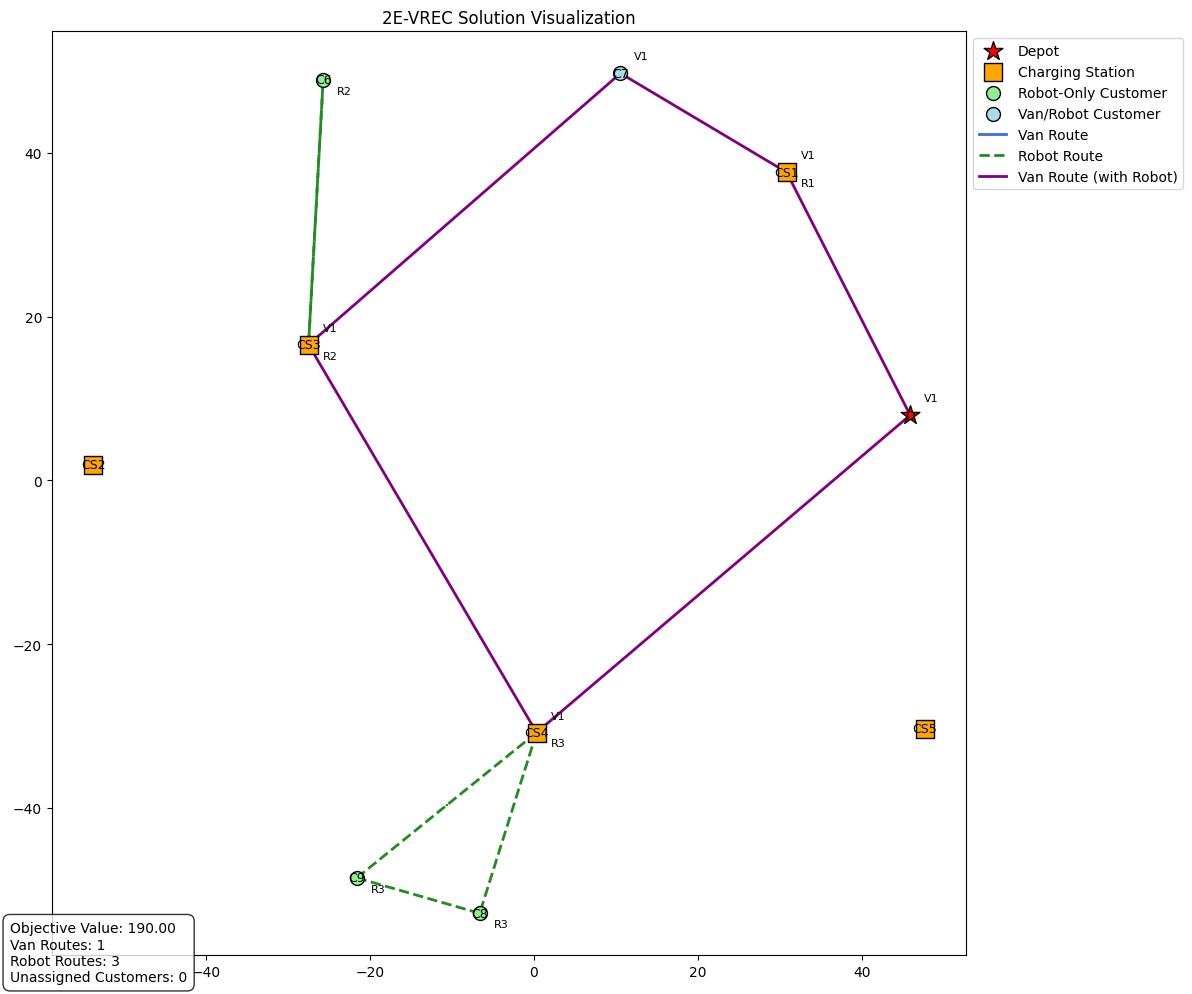

<Axes: >

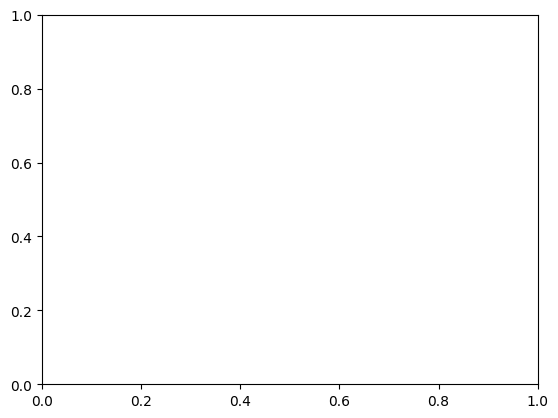

In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
def visualize_solution(solution, node_positions=None, figsize=(12, 10), save_path=None):
    """
    Visualize a VRPECSolution showing depot, charging stations, customers and routes.
    
    Parameters:
        solution: VRPECSolution object with the routing solution
        node_positions: Dict mapping node IDs to (x, y) coordinates. If None, will be generated using MDS.
        figsize: Size of the figure (width, height) in inches
        save_path: If provided, save the figure to this path
    """
    # Generate positions if not provided
    if node_positions is None:
        # Use MDS to transform distance matrix to 2D coordinates
        n_nodes = solution.distance_matrix.shape[0]
        
        # Make distance matrix symmetric by averaging with its transpose
        symmetric_distance_matrix = (solution.distance_matrix + solution.distance_matrix.T) / 2
        
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
        positions = mds.fit_transform(symmetric_distance_matrix)
        node_positions = {i: (positions[i, 0], positions[i, 1]) for i in range(n_nodes)}
        node_positions = {i: (positions[i, 0], positions[i, 1]) for i in range(n_nodes)}
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Define colors
    van_color = 'royalblue'
    robot_color = 'forestgreen'
    van_robot_color = 'purple'  # For when robot is on board
    
    # Plot nodes
    # Depot
    depot_x, depot_y = node_positions[solution.depot]
    plt.scatter(depot_x, depot_y, c='red', s=200, marker='*', edgecolors='black', zorder=10, label='Depot')
    
    # Charging stations
    station_x = [node_positions[s][0] for s in solution.charging_stations]
    station_y = [node_positions[s][1] for s in solution.charging_stations]
    plt.scatter(station_x, station_y, c='orange', s=150, marker='s', edgecolors='black', zorder=9, label='Charging Station')
    
    # Customers - robot only
    robot_only_x = [node_positions[c][0] for c in solution.customers_robot_only]
    robot_only_y = [node_positions[c][1] for c in solution.customers_robot_only]
    plt.scatter(robot_only_x, robot_only_y, c='lightgreen', s=100, marker='o', edgecolors='black', zorder=8, 
                label='Robot-Only Customer')
    
    # Customers - both van and robot
    both_x = [node_positions[c][0] for c in solution.customers_both]
    both_y = [node_positions[c][1] for c in solution.customers_both]
    plt.scatter(both_x, both_y, c='lightblue', s=100, marker='o', edgecolors='black', zorder=8,
                label='Van/Robot Customer')
    
    # Plot routes
    # Van routes
    for i, route in enumerate(solution.van_routes):
        if len(route.nodes) <= 1:
            continue
        
        for j in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[j], route.nodes[j + 1]
            x1, y1 = node_positions[node1]
            x2, y2 = node_positions[node2]
            
            # Check if robot is onboard
            robot_onboard = False
            if j < len(route.robot_onboard) and route.robot_onboard[j]:
                color = van_robot_color
                robot_onboard = True
            else:
                color = van_color
            
            plt.plot([x1, x2], [y1, y2], c=color, linewidth=2, zorder=5)
            
            # Add arrow to show direction
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            dx = x2 - x1
            dy = y2 - y1
            arrow_len = np.sqrt(dx**2 + dy**2)
            plt.arrow(mid_x - dx*0.1/arrow_len, mid_y - dy*0.1/arrow_len, 
                      dx*0.2/arrow_len, dy*0.2/arrow_len, 
                      head_width=0.015, head_length=0.03, fc=color, ec=color, zorder=6)
            
            # Annotate route number
            plt.annotate(f"V{i+1}", (x1, y1), xytext=(10, 10), 
                        textcoords='offset points', fontsize=8, zorder=7)
    
    # Robot routes
    for i, route in enumerate(solution.robot_routes):
        if len(route.nodes) <= 1:
            continue
        
        for j in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[j], route.nodes[j + 1]
            x1, y1 = node_positions[node1]
            x2, y2 = node_positions[node2]
            
            plt.plot([x1, x2], [y1, y2], c=robot_color, linewidth=2, linestyle='--', zorder=4)
            
            # Add arrow to show direction
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            dx = x2 - x1
            dy = y2 - y1
            arrow_len = np.sqrt(dx**2 + dy**2)
            plt.arrow(mid_x - dx*0.1/arrow_len, mid_y - dy*0.1/arrow_len, 
                      dx*0.2/arrow_len, dy*0.2/arrow_len, 
                      head_width=0.015, head_length=0.03, fc=robot_color, ec=robot_color, zorder=6)
            
            # Annotate route number
            plt.annotate(f"R{i+1}", (x1, y1), xytext=(10, -10), 
                        textcoords='offset points', fontsize=8, zorder=7)
    
    # Label nodes
    for node, (x, y) in node_positions.items():
        if node == solution.depot:
            label = "D"
        elif node in solution.charging_stations:
            label = f"CS{solution.charging_stations.index(node) + 1}"
        elif node in solution.all_customers:
            label = f"C{node}"
        else:
            continue
        
        plt.text(x, y, label, fontsize=9, ha='center', va='center', zorder=11)
    
    # Create custom legend entries for routes
    van_line = mlines.Line2D([], [], color=van_color, linewidth=2, label='Van Route')
    robot_line = mlines.Line2D([], [], color=robot_color, linewidth=2, linestyle='--', 
                              label='Robot Route')
    van_robot_line = mlines.Line2D([], [], color=van_robot_color, linewidth=2, 
                                  label='Van Route (with Robot)')
    
    # Get handles and labels from current plot
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Add route lines to legend
    handles.extend([van_line, robot_line, van_robot_line])
    
    # Create legend
    plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Plot information
    objective = solution.objective()
    num_van_routes = len([r for r in solution.van_routes if len(r.nodes) > 1])
    num_robot_routes = len([r for r in solution.robot_routes if len(r.nodes) > 1])
    
    info_text = (
        f"Objective Value: {objective:.2f}\n"
        f"Van Routes: {num_van_routes}\n"
        f"Robot Routes: {num_robot_routes}\n"
        f"Unassigned Customers: {len(solution.unassigned_customers)}"
    )
    
    plt.figtext(0.01, 0.01, info_text, va="bottom", ha="left", fontsize=10,
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))
    
    plt.title("2E-VREC Solution Visualization")
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return plt.gca()

# Example usage:
visualize_solution(best_solution)